In [319]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [320]:
class Node:
    def __init__(self, value, children = (), label = ''):
        self.value = value
        self.children = set(children)
        self.gradient = 0.0
        self.label = label
        self.backprop_function = lambda: None

    def __repr__(self):
        return f'Node(value = {self.value})'
    
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value + other.value, (self, other))

        def backprop_function():
            self.gradient += 1.0 * out.gradient
            other.gradient += 1.0 * out.gradient
        out.backprop_function = backprop_function
        return out
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.value * other.value, (self, other))

        def backprop_function():
            self.gradient += other.value * out.gradient
            other.gradient += self.value * out.gradient
        out.backprop_function = backprop_function

        return out

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return Node(self.value * -1, (self, ))

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        if isinstance(other, (int, float)):
            out = Node(self.value ** other, (self, ))

            def backprop_function():
                self.gradient += (other * (self.value) ** (other - 1)) * out.gradient
            out.backprop_function = backprop_function

            return out
        else: 
            raise TypeError(f'Unsupported operand type(s) for **: "Node" and "{type(other).__name__}"')

    def __truediv__(self, other):
        if isinstance(other, (int, float)):
            other = Node(other)
        out = Node(self.value * (other.value ** -1))

        return out

    def tanh(self):
        x = self.value
        e_2x = math.exp(2 * x)
        t = (e_2x - 1) / (e_2x + 1)
        out = Node(t, (self, ))

        def backprop_function():
            self.gradient += (1 - t ** 2) * out.gradient
        out.backprop_function = backprop_function

        return out

    def backward(self):
        sorted_nodes = []
        visited_nodes = set()

        # returns a topologically sorted list for backprop, depth-first search
        def topological_sort(node):
            if node not in visited_nodes:
                visited_nodes.add(node)

                for child in node.children:
                    topological_sort(child)

                sorted_nodes.append(node)

            return sorted_nodes

        backprop_order = topological_sort(self)[::-1]
        self.gradient = 1.0

        # we need to store a function in each Node that tells us now how to backprop
        # this depends on the operation (local derivative of each operation is needed in chain rule)
        # so it makes sense to update the function for backprop for each node based on what operation created it (I think)
        # ultimately this function has to update the gradient of self based on the parent i.e. out
        # perhaps that is it? it we call o.backward(), it should iterate through every dependency and update self.gradient to the end???
        # ???
        # profit
        # oh wait there can be multiple nodes in current operation i.e. add, so basically we need to update the children 

        for node in backprop_order:
            node.backprop_function()
            print(f'{node.label}.gradient = {round(node.gradient, 2)}')
        
        


In [321]:
# doing the forward pass and evaluating the neural network's overall expression\
x1 = Node(2.0, label = 'x1')
w1 = Node(-3.0, label = 'w1')

x2 = Node(0.0, label = 'x2')
w2 = Node(1.0, label = 'w2')

w1x1 = w1 * x1
w1x1.label = 'w1x1'
w2x2 = w2 * x2
w2x2.label = 'w2x2'

sum_w_x = w1x1 + w2x2
sum_w_x.label = 'sum_w_x'

b = Node(6.8813735870195432, label = 'b')
n = sum_w_x + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

print('Forward Pass Values')
print('---')
print(f'o = {o.value}')
print(f'n = {n.value}')
print(f'sum_w_x = {sum_w_x.value}')
print(f'b = {b.value}')
print(f'w1x1 = {w1x1.value}')
print(f'w2x2 = {w2x2.value}')
print(f'x1 = {x1.value}')
print(f'w1 = {w1.value}')
print(f'x2 = {x2.value}')
print(f'w2 = {w2.value}')
print('---')

print("Let's try doing backprop...")
o.backward()
# print('---')
# print(f'o.gradient = {o.gradient}')
# print(f'n.gradient = {n.gradient}')
# print(f'b.gradient = {b.gradient}')
# print(f'sum_w_x.gradient = {sum_w_x.gradient}')
# print(f'w1x1.gradient = {w1x1.gradient}')
# print(f'w2x2.gradient = {w2x2.gradient}')
# print(f'x1.gradient = {x1.gradient}')
# print(f'w1.gradient = {w1.gradient}')
# print(f'x2.gradient = {x2.gradient}')
# print(f'w2.gradient = {w2.gradient}')
# print('---')


Forward Pass Values
---
o = 0.7071067811865476
n = 0.8813735870195432
sum_w_x = -6.0
b = 6.881373587019543
w1x1 = -6.0
w2x2 = 0.0
x1 = 2.0
w1 = -3.0
x2 = 0.0
w2 = 1.0
---
Let's try doing backprop...
o.gradient = 1.0
n.gradient = 0.5
b.gradient = 0.5
sum_w_x.gradient = 0.5
w1x1.gradient = 0.5
w1.gradient = 1.0
x1.gradient = -1.5
w2x2.gradient = 0.5
w2.gradient = 0.0
x2.gradient = 0.5


In [322]:
# we need to build a list of nodes that build up the entire expression in the forward pass
# we need these to be ordered, i.e. x1, w1 comes before x1w1 and so on
# all depedency nodes must come before their parent nodes (parent in terms of backprop direction)
# this is called a topological sort for a computational graph like ours (a DAG)
# this is the result of me stepping through and building it from scratch, so pardon the language (both french and python)

sorted_nodes = []
visited_nodes = set()

print('Welcome to my shitshow of a topological sort 👋')
def topological_sort(node):
    # print(f'top level: topological_sort({node.label})')
    print('---')
    if node not in visited_nodes:
        print(f'{node.label} is not in visited_nodes')
        print(f'Adding {node.label} to visited_nodes')
        visited_nodes.add(node)

        print(f'visited_nodes update: {[node.label for node in visited_nodes]}')
    
        for child in node.children:
            print(f'for {child.label} in {[child.label for child in node.children]}')
            print(f'⬇️ topological_sort({child.label}) ⬇️')
            topological_sort(child)
            print(f'sorted_nodes.append({child.label})')
            print(f'sorted_nodes update: {[node.label for node in sorted_nodes]}')

        sorted_nodes.append(node)
    return sorted_nodes

sorted_nodes = topological_sort(o)
sorted_labels = [node.label for node in sorted_nodes]
print(f'final sorted nodes: {sorted_labels}')
sorted_labels.reverse()
print(f'reversed sorted nodes: {sorted_labels}')


Welcome to my shitshow of a topological sort 👋
---
o is not in visited_nodes
Adding o to visited_nodes
visited_nodes update: ['o']
for n in ['n']
⬇️ topological_sort(n) ⬇️
---
n is not in visited_nodes
Adding n to visited_nodes
visited_nodes update: ['o', 'n']
for sum_w_x in ['sum_w_x', 'b']
⬇️ topological_sort(sum_w_x) ⬇️
---
sum_w_x is not in visited_nodes
Adding sum_w_x to visited_nodes
visited_nodes update: ['sum_w_x', 'o', 'n']
for w2x2 in ['w2x2', 'w1x1']
⬇️ topological_sort(w2x2) ⬇️
---
w2x2 is not in visited_nodes
Adding w2x2 to visited_nodes
visited_nodes update: ['sum_w_x', 'w2x2', 'o', 'n']
for x2 in ['x2', 'w2']
⬇️ topological_sort(x2) ⬇️
---
x2 is not in visited_nodes
Adding x2 to visited_nodes
visited_nodes update: ['o', 'sum_w_x', 'x2', 'n', 'w2x2']
sorted_nodes.append(x2)
sorted_nodes update: ['x2']
for w2 in ['x2', 'w2']
⬇️ topological_sort(w2) ⬇️
---
w2 is not in visited_nodes
Adding w2 to visited_nodes
visited_nodes update: ['o', 'w2', 'sum_w_x', 'x2', 'n', 'w2x2']
s

In [323]:
import random

class Neuron:
    # create a Neuron with i inputs
    def __init__(self, i):
        self.weights = [Node(random.uniform(-1,1)) for _ in range(i)]
        self.bias = Node(random.uniform(-1,1))
    
    # forward pass of Neuron
    def __call__(self, input):
        # w * x + b where * is dot product
        n = sum((w_i * x_i for w_i, x_i in zip(self.weights, input)), self.bias)
        out = n.tanh()
        return out

# forward pass with 2-dimensional input vector
# weights randomly generated between 0 and 1
input = [2.0, 3.0]
neuron = Neuron(len(input))
neuron(input)


Node(value = -0.8359186656076226)

In [324]:
# layer of neurons is a set of neurons evaluated independently

class Layer:
    def __init__(self, length_of_input, number_of_neurons):
        self.neurons = [Neuron(length_of_input) for _ in range(number_of_neurons)]

    # do a forward pass for the layer
    # evaluate each Neuron's forward pass
    def __call__(self, input):
        out = [neuron(input) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out

input = [2.0, 3.0, 5.0]
length_of_input = len(input)
number_of_neurons = 3
layer = Layer(length_of_input, number_of_neurons)

# forward pass of the layer
layer(input)

[Node(value = -0.3242015267935414),
 Node(value = 0.9999374934853518),
 Node(value = -0.32097082106911135)]

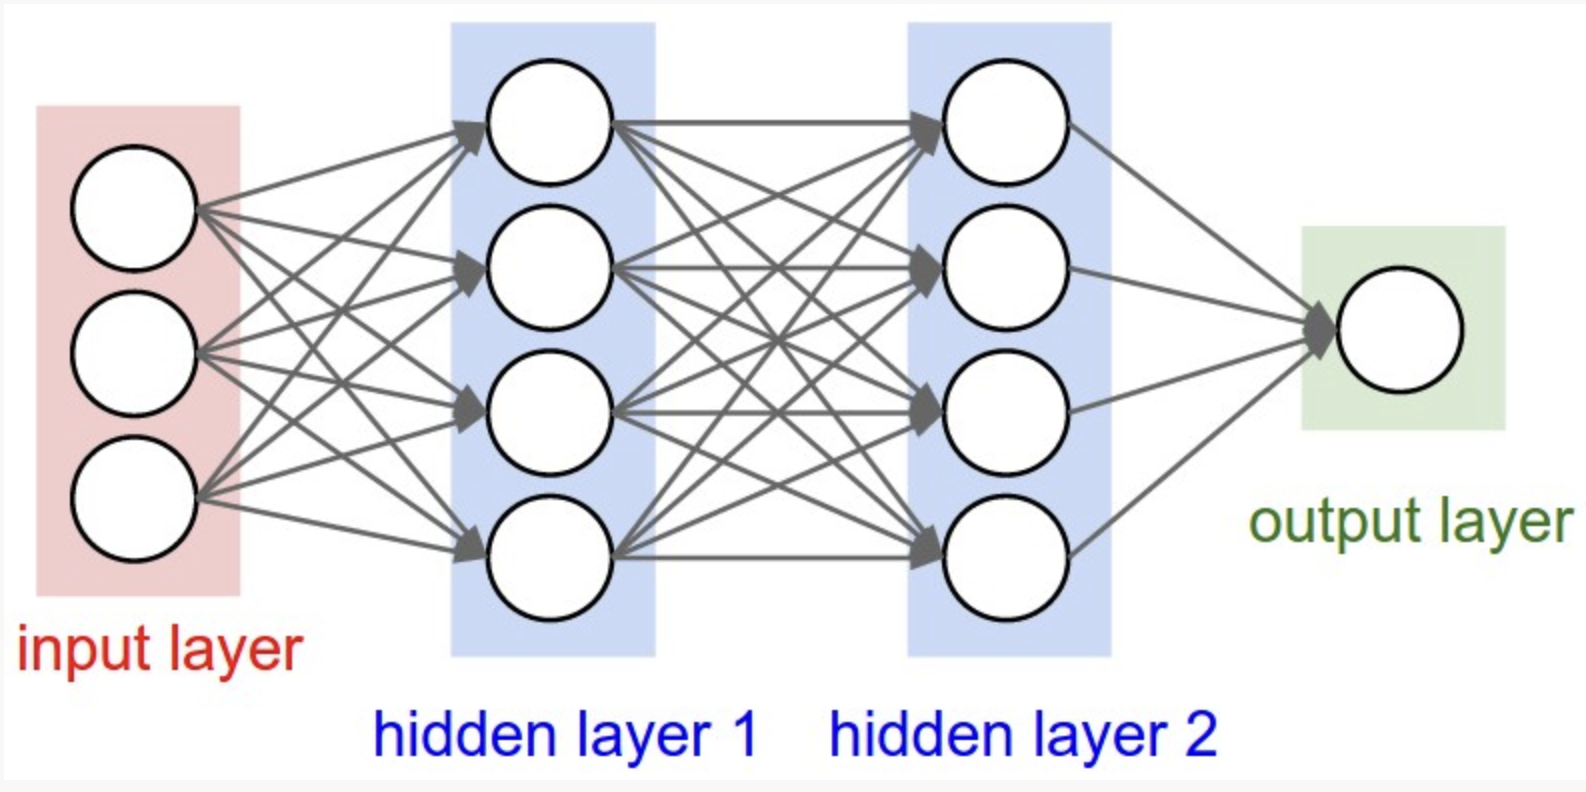

In [325]:
# multi-layer perceptron
class MLP:
    # length_of_input_layer = 3
    # sizes_of_other_layers = [4, 4, 1]
    def __init__(self, length_of_input_layer, length_of_other_layers):
        layer_lengths = [length_of_input_layer] + length_of_other_layers
        # should be [3, 4, 4, 1]
        # want to create three layers, the input_layer is not defined here, though we could pass that through and add it on the front through __call__
        self.layers = [Layer(layer_lengths[i], layer_lengths[i + 1]) for i in range(len(length_of_other_layers))]
    
    def __call__(self, input):
        for layer in self.layers:
            out = layer(input)
        return out
    
# we want an MLP that recreates the image above
# i guess it's up to me how I define the number of layers tbh, it makes sense to me to have 4 layers here
# is the last layer doing anything though? yes it has an input so it should do something, so 4 layers it is for now

# need to define:
# number_of_layers in MLP
# number_of_neurons in each layer
# length_of_input (i.e. size of previous layer) to each layer

# Layer is defined with layer = Layer(length_of_input, number_of_neurons)

# always start with the input layer

input_layer = [2.0, 3.0, -1.0]
# define the dimensions of the MLP
mlp = MLP(len(input_layer), [4, 4, 1])

# do a forward pass of the NLP
out = mlp(input_layer)
print(out)


Node(value = 0.6101836849143795)


In [326]:
inputs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]] # inputs
desired_outputs = [1.0, -1.0, -1.0, 1.0] # desired targets

# in the video he just rawdogs n(x) for x in xs, his n is our mlp.
# ah! he is doing multiple forward passes for the same network. 
# inputs is like input_layer above, but with multiple first input layers, and then the rest of the network is auto generated with random weights and biases
# such that the values that come out are the final output neuron in the final layer of size 1
# therefore, we have four different outputs we want to match to four different input layers, so effectively four trainings of the same mlp



predicted_outputs = [mlp(input) for input in inputs]
print(predicted_outputs)

# how do we tune the weights to predicted the desired_outputs? 
# the loss

[Node(value = 0.6101836849143795), Node(value = -0.9963234294741655), Node(value = -0.2933251372289528), Node(value = 0.6000190898798816)]


In [327]:
mean_squared_errors = [(predicted_output - desired_output)**2 for desired_output, predicted_output in zip(desired_outputs, predicted_outputs)]
loss = sum(mean_squared_errors)

print(loss)

Node(value = 0.8113443668107598)


In [328]:
loss.backward()

.gradient = 1.0
.gradient = 1.0
.gradient = 1.0
.gradient = 1.41
.gradient = 1.41
.gradient = 1.41
.gradient = 1.29
.gradient = 1.29
.gradient = 1.29
.gradient = 0.6
.gradient = 1.29
.gradient = 1.29
.gradient = -1.18
.gradient = 1.29
.gradient = -0.94
.gradient = 1.0
.gradient = 1.0
.gradient = 1.0
.gradient = -0.78
.gradient = -0.78
.gradient = -0.49
.gradient = -0.49
.gradient = 0.36
.gradient = -0.49
.gradient = -0.49
.gradient = -0.49
.gradient = 0.45
.gradient = -0.49
.gradient = -0.23
.gradient = -0.78
.gradient = 1.0
.gradient = 1.0
.gradient = 0.01
.gradient = 0.01
.gradient = 0.0
.gradient = 0.0
.gradient = 0.0
.gradient = 0.0
.gradient = 0.0
.gradient = 0.0
.gradient = -0.0
.gradient = 0.0
.gradient = -0.0
.gradient = 0.01
.gradient = 1.0
.gradient = -0.8
.gradient = -0.8
.gradient = -0.8
.gradient = -0.51
.gradient = -0.51
.gradient = 2.29
.gradient = 0.37
.gradient = -0.51
.gradient = -0.51
.gradient = -0.24
.gradient = -0.69
.gradient = -0.51
.gradient = 0.29
.gradient = 